# Amazon Review Helpfulness Prediction 

## Problem Statement:
In this project, we are tring to address the bias associated with the amazon review helpfulness which is currently ranked based on the number of upvotes the review received. We will use machine learning techniques to design a model which will predict or classify the review whether it is helpful or not helpful.The final outcome of the project is how well we are able to predict the new review as helpful or not helpful.

For the problem statement, we will use the Home and Kitchen dataset which is having around 346,355 reviews. Dataset is available at JmCauley page: http://jmcauley.ucsd.edu/data/amazon/links.html

## Data Analysis

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd
import gzip
import math, time, random, datetime
import string
import nltk
#nltk.download('stopwords')

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from IPython.display import display # Allows the use of display() for DataFrames

In [2]:
import os
# Loading the home and kitchen dataset which is downloaded in the /data path
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i +=1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF('../data/raw/reviews_Home_and_Kitchen_5.json.gz')    

In [3]:
# Lets look at the data
data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


As mentioned in the jmcauley site, belaw are the description of the fields:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3.
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)


As per the problem statement of the project, lets extract the useful information needed:
1. 'reviewText' which will be used to generate the features
2. 'helpful'. As it is an array of helpful_ratings and total ratings . We will split them and predict the helpful ratings and use it as target labels.
3. 'overall' as one of the feature. We will see if there is any correlation between overall and helpful_ratings and check if it can help in improving the performance of the model.
4. 'unixReviewTime. In case if we would like to give importance to review based on review date, preferring new review over old review.

In [4]:
# Extracting the useful columns from the data
df = data.loc[:, ['helpful', 'reviewText', 'overall']]

# Split the helpful into helpful_ratings and total_ratings
df['helpful_ratings'] = df['helpful'].apply(lambda x: x[0])
df['total_ratings'] = df['helpful'].apply(lambda x: x[1])

# Delete helpful from df
del df['helpful']

# Convert unixReviewTimestamp to date format 'YYYY-MM-DD'
#df['reviewDate'] = df['unixReviewTime'].apply(lambda x : datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
#df['reviewYear'] = pd.DatetimeIndex(df['reviewDate']).year

# Delete unixReviewtime from df
#del df['unixReviewTime']

# Check if there is any null values
print(df.isnull().sum())

reviewText         0
overall            0
helpful_ratings    0
total_ratings      0
dtype: int64


In [5]:
# Check the df statistics
df.describe()

,overall,helpful_ratings,total_ratings
count,551682.000000,551682.000000,551682.000000
mean,4.316655,3.497348,3.939469
std,1.110749,76.539142,77.801556
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000
max,5.000000,52176.000000,52861.000000


There is clearly some outliers in the data as there is huge difference between max and min value of helpful_ratings and total_ratings. Lets move to exploratory visualization for finding some insights on this.

## Exploratory Visualization 

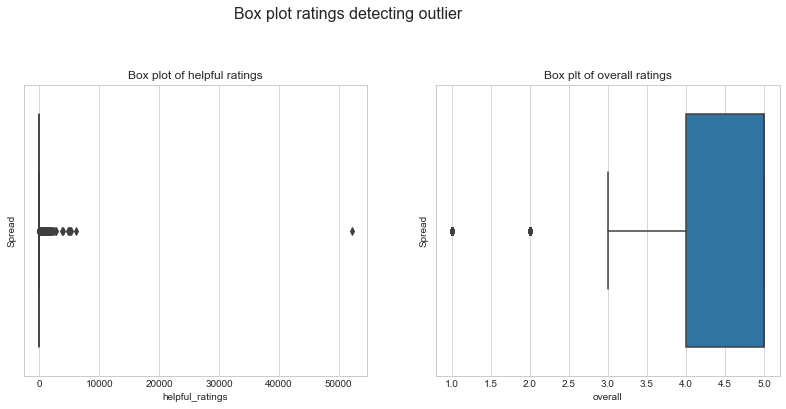

In [6]:
### Box Plot
plt.subplots(1,2, figsize=(15,6))

plt.subplot(121)
plt.title('Box plot of helpful ratings')
plt.xlabel('Helpful ratings')
plt.ylabel('Spread')
sns.boxplot(x=df['helpful_ratings'])

plt.subplot(122)
plt.title('Box plt of overall ratings')
plt.xlabel('overall ratings')
plt.ylabel('Spread')
sns.boxplot(x=df['overall'])

plt.suptitle('Box plot ratings detecting outlier', fontsize=16)

plt.subplots_adjust(left=0.2, wspace=0.2, top=0.8)
plt.show()

In [7]:
#df[df.helpful_ratings > 50000]
print(df['helpful_ratings'].idxmax(axis=0, skipna=True))
print(df['total_ratings'].idxmax(axis=0, skipna=True))

396128
396128


In [8]:
df.iloc[[396128]]

,reviewText,overall,helpful_ratings,total_ratings
396128,For decades I have been trying to come up with...,5.0,52176,52861


The reviewText looks fine. And we can ignore the extreme of helpful/total ratings as we are going to label the helpful ratings based on certain threshold.

In [9]:
df[df.overall == 1].count()

reviewText         27106
overall            27106
helpful_ratings    27106
total_ratings      27106
dtype: int64

In [10]:
df[df.overall == 2].count()

reviewText         24313
overall            24313
helpful_ratings    24313
total_ratings      24313
dtype: int64

The count of "overall" ratings of 1 and 3 is around 25000, we can't drop these rows as we might loose some important information.

## Data Preprocessing 

Lets first create the target label that is "helpful" based on the certain threshold say 0.50. If (helpful_ratings/total_ratings) > 0.50, then the review is helpful, else not helpful.
For achieving this we have to consider the review whose total_ratings is greater than 0.
 

In [11]:
# Separing the data with total_ratings as 0. Use this data for unsupervised learning in future
#df1 = df[(df.total_ratings == 0)].copy()
#df1.head(5)

In [12]:
# Use data with total_ratings > 0 for creating target label "helpful"
#df2 = df[(df.total_ratings > 0)].copy()
#df2.shape

In [13]:
#include reviews that have more than 10 helpfulness data point only
df1 = df[(df.total_ratings > 10)].copy()
df1.shape

(33824, 4)

In [14]:
# Transform helpfulness as a binary feature with threshold of 0.50
threshold=0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_ratings']/df1.loc[:, 'total_ratings'] > threshold, 1, 0)
df1.head(5)

,reviewText,overall,helpful_ratings,total_ratings,Helpful
2,There is no shortage of pop recipes available ...,4.0,26,27,1
3,This book is a must have if you get a Zoku (wh...,5.0,14,18,1
7,I bought this when I bought the pop maker. I t...,2.0,32,39,1
8,"The Zoku accessories are pricey, but the recip...",5.0,13,13,1
14,This book is absolutely beautiful. A brilliant...,5.0,16,16,1


In [15]:
# Check the distribution of helpful and non-helpful reviews
display(df1.groupby('Helpful').count())

,reviewText,overall,helpful_ratings,total_ratings
Helpful,,,,
0,1972,1972,1972,1972
1,31852,31852,31852,31852


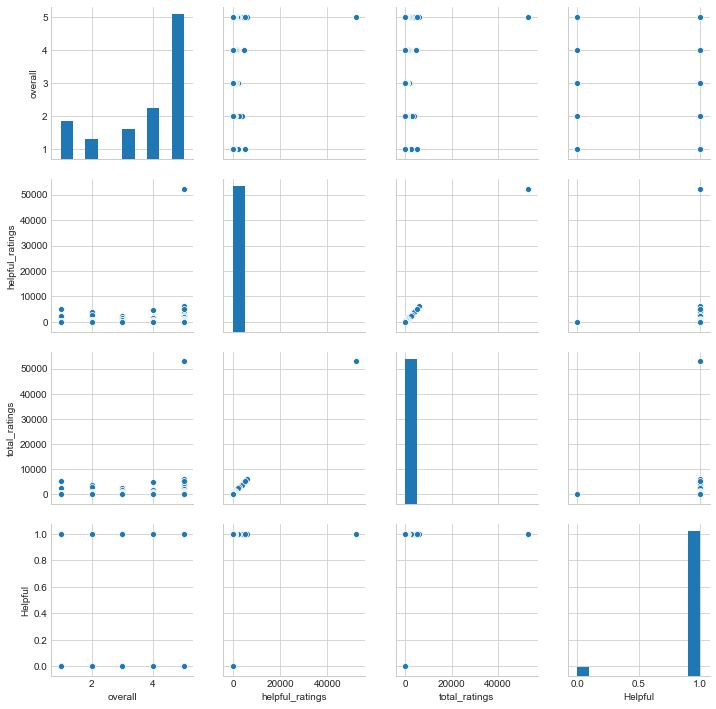

In [16]:
# Pairplot Visualization
sns.pairplot(df1)

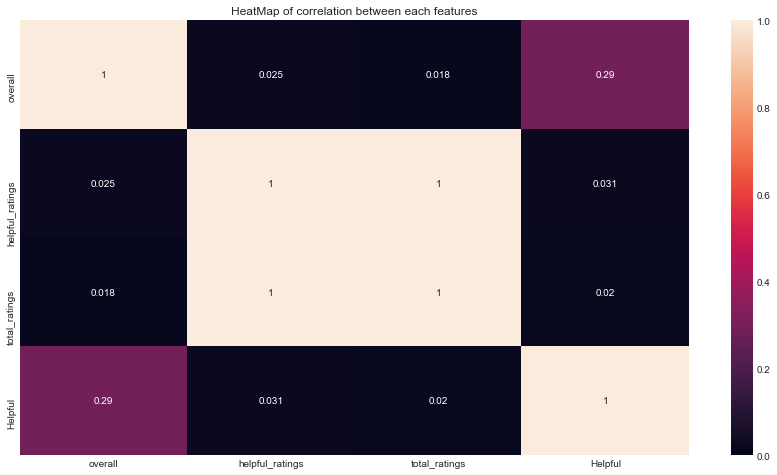

In [17]:
# Visualizing correlation of the data
correlations = df1.corr()
plt.figure(figsize=(15,8))
plt.title('HeatMap of correlation between each features')
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

With these distribution, it is clear that our dataset is unbalanced, with roughly around 7 to 8 times as many helpful reviews as compared to not helpful reviews. For proper distribution of both category of data, we will use StratifiedShuffle while splitting the train test data.

There is very small correlation between overall score and helpful. As this correlation is small, we have to generate reviewText feature generaion for predicting the review helpfulness.

In [ ]:
#uniform_subset_dataset =df2[(df2.Helpful == 1)].sample(frac=.25).reset_index(drop=True).copy()
#uniform_subset_dataset = uniform_subset_dataset.append(df2[(df2.Helpful == 0)], ignore_index=True)
#uniform_subset_dataset.head()

In [ ]:
# Check the distribution of helpful and non-helpful reviews
#display(uniform_subset_dataset.groupby('Helpful').count())

#### Review Text Feature Generation

For generating the text feature, we will use below text preprocessing steps which is common while handling text data:
1. Tokenization: convert sentences to words
2. Removing unnecessary punctuation words, tags, etc
3. Removing stop words: frequent words such as "the", "if", "is" that doesnot have specific semantic
4. Stemming: words are reduced to a root by removing the inflection by dropping unnecessary characters usually a suffix
5. Lemmatization: Another approach to remove inflection by determining the part of speech and utilizing detailed database of the language.

I want to experiment on traditional and deep learning way of approach for handling the text features.
For traditional approach, I would use TF-IDF(Term Frequency-Inverse Document Frequency) approach
One with Unsupervised learning approach, maybe Glove or Skip-n grams approach we will decide.

Let's first start with TF-IDF approach of word embeddings.

#### TF-IDF 

This approach of word embeddings is based on frequency method. It takes into account not just the occurrence of a word in a single document but in the entire corpus.
TF-IDF works by penalising the common words occurring across the documents by weighing down the common words that occur in almost every document (e.g. “the” or “a”) and give more importance to those that appear only in a few documents.

In detail, TF IDF is composed of two parts: TF which is the term frequency of a word, i.e. the count of the word occurring in a document and IDF, which is the inverse document frequency, i.e. the weight component that gives higher weight to words occuring in only a few documents.

Mathematically, we can define TF-IDF as tfidf = tf x idf, which can be expanded further to be represented as follows.

tfidf(w,D) = tf(w,D)* idf(w,D) = tf(w,D) * log(C/df(w))

Here, tfidf(w, D) is the TF-IDF score for word w in document D. The term tf(w, D) represents the term frequency of the word w in document D, which can be obtained from the Bag of Words model. The term idf(w, D) is the inverse document frequency for the term w, which can be computed as the log transform of the total number of documents in the corpus C divided by the document frequency of the word w, which is basically the frequency of documents in the corpus where the word w occurs.

For generating the etxt features we will use Tfidf vetorizer from scikit learn and NLTK library for text preprocessing.

Let's convert the text into lower case to run natural language processing for producing features.We will also remove punctuation. Removing punctuation may seem like it should not be done in the case of this problem, as not having punctuation will make a review harder to understand. This is a trade-off that we must consider. If we include punctuation, it will cause the learning algorithm to behave poorly.

In [18]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [19]:
import re
#contraction_dict = {"aint": "is not", "arent": "are not","cant": "cannot", "'cause": "because", "couldve": "could have", "couldnt": "could not", "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not", "hasnt": "has not", "havent": "have not", "hed": "he would","he'll": "he will", "hes": "he is", "howd": "how did", "howdy": "how do you", "howll": "how will", "hows": "how is",  "Id": "I would", "Idve": "I would have", "Ill": "I will", "Illve": "I will have","Im": "I am", "Ive": "I have", "id": "i would", "idve": "i would have", "i'll": "i will",  "illve": "i will have","im": "i am", "ive": "i have", "isnt": "is not", "itd": "it would", "itdve": "it would have", "itll": "it will", "itllve": "it will have","its": "it is", "lets": "let us", "maam": "madam", "maynt": "may not", "mightve": "might have","mightnt": "might not","mightntve": "might not have", "mustve": "must have", "mustnt": "must not", "mustntve": "must not have", "neednt": "need not", "neednt've": "need not have","oclock": "of the clock", "oughtnt": "ought not", "oughtntve": "ought not have", "shant": "shall not", "shant": "shall not", "shantve": "shall not have", "shed": "she would", "shedve": "she would have", "shell": "she will", "shellve": "she will have", "shes": "she is", "shouldve": "should have", "shouldnt": "should not", "shouldntve": "should not have", "sove": "so have","sos": "so as", "thiss": "this is","thatd": "that would", "thatdve": "that would have", "thats": "that is", "thered": "there would", "theredve": "there would have", "theres": "there is", "heres": "here is","theyd": "they would", "theydve": "they would have", "theyll": "they will", "theyll've": "they will have", "theyre": "they are", "theyve": "they have", "tove": "to have", "wasnt": "was not", "wed": "we would", "wedve": "we would have", "we'll": "we will", "wellve": "we will have", "we're": "we are", "weve": "we have", "werent": "were not", "whatll": "what will", "whatllve": "what will have", "whatre": "what are",  "whats": "what is", "whatve": "what have", "whens": "when is", "whenve": "when have", "whered": "where did", "wheres": "where is", "whereve": "where have", "wholl": "who will", "whollve": "who will have", "whos": "who is", "whove": "who have", "whys": "why is", "whyve": "why have", "willve": "will have", "wont": "will not", "wontve": "will not have", "wouldve": "would have", "wouldnt": "would not", "wouldntve": "would not have", "yall": "you all", "yalld": "you all would","yalld've": "you all would have","yallre": "you all are","yallve": "you all have","youd": "you would", "youdve": "you would have", "youll": "you will", "youllve": "you will have", "youre": "you are", "youve": "you have"}
contraction_dict = {"aint": "is not", "arent": "are not","cant": "cannot", "'cause": "because", "couldve": "could have", "couldnt": "could not", "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not", "hasnt": "has not", "havent": "have not", "wasnt": "was not", "isnt": "is not", "shouldnt": "should not", "thats": "that is"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [20]:
# Misspelling corrections
mispell_dict = {"complis": "complies", "wellmade": "well-made", "onoff": "on/off", "kitchenaid": "kitchemaid", "roomba": "room", "appare": "apparel", "bodrum": "bodrum", "notly": "hotly", "kcup": "cup", "kcups": "cups", "krups": "cups", "roomthe":"room the"}
def _get_mispell(contraction_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_mispell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [21]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_text(text):
    # lower case and remove special characters\whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    text = clean_text(text)
    text = replace_contractions(text)
    text = replace_typical_mispell(text)
    # tokenize document
    tokens = wpt.tokenize(text)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    text = ' '.join(filtered_tokens)
    return text

#normalize_corpus = np.vectorize(normalize_document)
normalize_corpus = df1['reviewText'].apply(lambda x: normalize_text(x))
normalize_corpus.head()

2     shortage pop recipes available free web purcha...
3     book must get zoku also highly recommend large...
7     bought bought pop maker think recipes fine rea...
8     zoku accessories pricey recipes exact amount n...
14    book absolutely beautiful brilliant bedtime st...
Name: reviewText, dtype: object

In [ ]:
#from sklearn.model_selection import train_test_split
# Split the normalized corpus into training and test data
#X_train, X_test, y_train, y_test = train_test_split(normalize_corpus, uniform_subset_dataset['Helpful'], test_size=0.3, random_state=42)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Defining the Tfidf vectorizer
vectorizer = TfidfVectorizer(min_df=0.01, max_df=1., ngram_range=(1, 1))
#fit the vectorizers to the data.
features = vectorizer.fit_transform(normalize_corpus)
features

<33824x1524 sparse matrix of type '<class 'numpy.float64'>'
	with 1985529 stored elements in Compressed Sparse Row format>

In [23]:
def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """
      get the feature names and tf-idf score of top n items in the doc,                 
      in descending order of scores. 
    """

    # use only top n items from vector.
    sorted_items = sorted_items[:topn]

    results= {} 
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        results[feature_names[idx]] = round(score, 3)

    # return a sorted list of tuples with feature name and tf-idf score as its element(in descending order of tf-idf scores).
    return sorted(results.items(), key=lambda kv: kv[1], reverse=True)

feature_names = vectorizer.get_feature_names()
coo_matrix = features.tocoo()
tuples = zip(coo_matrix.col, coo_matrix.data)
sorted_items = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

# extract only the top n elements.
# Here, n is 10.
word_tfidf = extract_topn_from_vector(feature_names, sorted_items, 15)

print("{}  {}".format("features", "tfidf"))  
for k in word_tfidf:
    print("{} - {}".format(k[0], k[1])) 

features  tfidf
best - 1.0
scale - 0.914
hair - 0.913
rice - 0.905
block - 0.901
mattress - 0.9
pillow - 0.896
grill - 0.895
tea - 0.895
garlic - 0.894
size - 0.892


We have  generated all our features that we are going to use.

## Baseline Model 

A model that is quick and often used for text classification is GaussianNB, We will use this as quick way to get a benchmark ROC_AUC score for the project.

ROC Curve(Receiver Operating Characteristics) curve is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0.

The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive. This is also referred as sensitivity.
True Positive Rate = True Positives / (True Positives + False Negatives)

The false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives.

It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.

False Positive Rate = False Positives / (False Positives + True Negatives)

The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.

Specificity = True Negatives / (True Negatives + False Positives)
Where False Positive Rate = 1 - Specificity

The ROC curve is a useful tool for a few reasons:

The curves of different models can be compared directly in general or for different thresholds.
The area under the curve (AUC) can be used as a summary of the model skill.
The shape of the curve contains a lot of information, including what we might care about most for a problem, the expected false positive rate, and the false negative rate.

To make this clear:

- Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
- Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.


For this purpose, we will split the data into 80% training and 20% testing. The benefit to splitting the data into testing and training sets is that this allows simulated evaluation of how well the model is performing before using it in the real world to make predictions.If there was no testing set, there would be no way of realistically evaluating the model as you would only be able to measure it's performace on data to which it's already been exposed. This will result in a false sense of confidence in how well the model performs.

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

def train_classifier(clf, X_train, y_train):
    ''' Fit a classifier to the training data'''
    #clf = GaussianNB()
    # Check the timings for training the classifier
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    
    # Print the results
    print('Trained model in {:4f} seconds'.format(end - start))

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score '''
    # Check the timings for making predictions
    start = time.time()
    probas = clf.predict_proba(features)
    end = time.time()
    
    # Print and return the results
    print('Predictions in {:4f} seconds'.format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifier based on roc_auc score. '''
    
    # Indicate the classifier and training set size
    print('Training a {} using a training set size of {}'.format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of predictcion for both the training and testing
    print('ROC_AUC score for training set: {:4f}'.format(predict_labels(clf, X_train, y_train)))
    print('ROC_AUC score for test set: {:4f}'.format(predict_labels(clf, X_test, y_test)))

def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    ''''''
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

Now lets train and predict using our benchmark model.

In [25]:
# split the datasets into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df1['Helpful'], test_size=0.3, random_state=42)

# densify sparse matrices
x_tr = X_train.toarray()
x_te = X_test.toarray()

# Train and predict
#train_predict(gnb, X_train, y_train, X_test, y_test)
train_predict(GaussianNB(), x_tr, y_train, x_te, y_test)

Training a GaussianNB using a training set size of 23676
Trained model in 1.106317 seconds
Predictions in 1.475092 seconds
ROC_AUC score for training set: 0.826479
Predictions in 0.589637 seconds
ROC_AUC score for test set: 0.684530


ROC_AUC score is not that great. We will look at improving this score

ROC score doesnot look good. So will try different word embeddings as Word2Vec and FastText

### Word2Vec 

This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include,
1. The Continuous Bag of Words (CBOW) Model
2. The Skip-gram Model

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). Considering a simple sentence, “the quick brown fox jumps over the lazy dog”, this can be pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on. Thus the model tries to predict the target_word based on the context_window words.

The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word. For instance, it will have two vector representations for Apple, one for the company and another for the fruit.

Genism word2vec requires that a format of ‘list of lists’ for training where every document is contained in a list and every list contains lists of tokens of that document.

We will use the same text preprocessing which we used for Tf-idf process.

In [26]:
# Split the normalized corpus into training and test data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(normalize_corpus, df1['Helpful'], test_size=0.3, random_state=42)

In [27]:
from gensim.models import Word2Vec

# build word2vec model train
wpt = nltk.WordPunctTokenizer()
tokenized_corpus_tr = [wpt.tokenize(document) for document in X_train_w2v]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 5    # Context window size                                                                                    
min_word_count = 2    # Minimum word count                        
sample = 1e-3         # Downsample setting for frequent words

w2v_model_train = Word2Vec(tokenized_corpus_tr, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=10)
                              

In [28]:
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test_w2v]

w2v_model_test = Word2Vec(tokenized_corpus_test, size=feature_size,
                         window=window_context, min_count=min_word_count,
                         sample=sample, iter=10)

In [29]:
#from gensim.models import Word2Vec

#w2v_model = Word2Vec(word2vec_input, min_count=2,size= 100,workers=3, window =3, sg = 1)

In [30]:
# Checking some word similarities
w2v_model_train.wv.most_similar(positive = 'pillow')

[('pillows', 0.8834260702133179),
 ('topper', 0.8232911825180054),
 ('mattress', 0.7946944236755371),
 ('pillowcase', 0.7348007559776306),
 ('bed', 0.7315224409103394),
 ('mattresses', 0.7306724190711975),
 ('comforter', 0.7227046489715576),
 ('sleep', 0.7144194841384888),
 ('sleeping', 0.695974588394165),
 ('neck', 0.688818097114563)]

This looks good!

In [31]:
# Lets check similarity between two different words
w2v_model_train.wv.similarity(w1='awesome', w2='memory')

-0.075171925

In [32]:
w2v_model_train.wv.similarity(w1='awesome', w2='satisfactorily')

0.15363085

#### t-SNE Visualization:

t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.
It is a useful tool to visualize high-dimensional data by dimension reduction while keeping relative pairwise distance between points. 

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

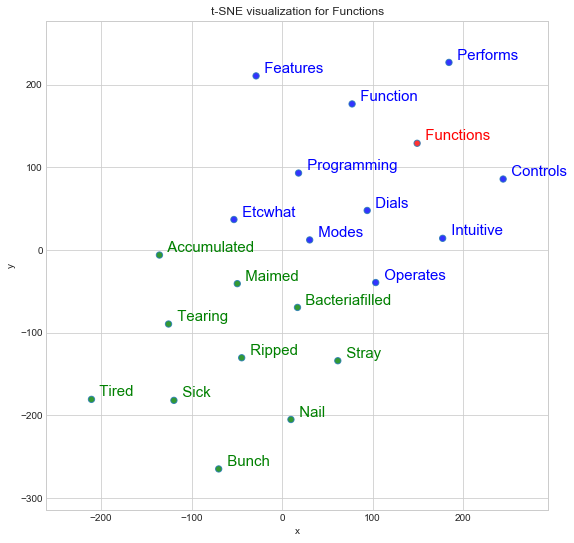

In [34]:
# Let's compare where the vector representation of 'functions' and 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to 'functions'
tsnescatterplot(w2v_model_train, 'functions', [i[0] for i in w2v_model_train.wv.most_similar(negative=["functions"])])

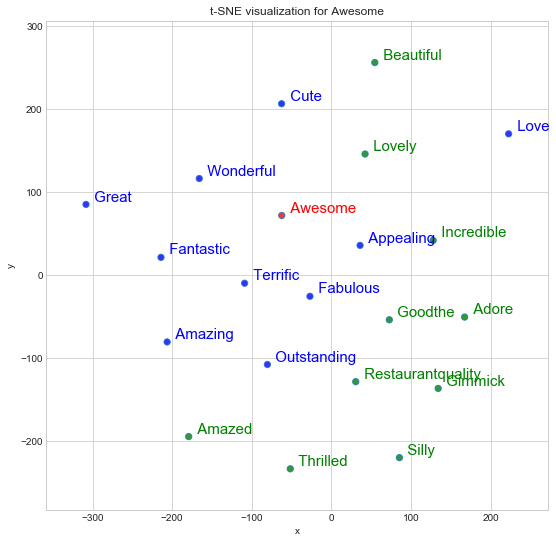

In [35]:
# Plot the most similar words to  ranked 1st to 10th versus the ones ranked 11th to 20th:
tsnescatterplot(w2v_model_train, "awesome", [t[0] for t in w2v_model_train.wv.most_similar(positive=["awesome"], topn=20)][10:])

In [ ]:
#def document_vector(doc):
 #   '''Create document vectors by averaging word vectors. Remove out-of-vocabulary words.'''
  #  doc = [word for word in doc if word in w2v_model.wv.vocab]
  #  return np.mean(w2v_model[doc], axis=0)

In [36]:

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings for training features
w2v_feature_array_tr = averaged_word_vectorizer(corpus=tokenized_corpus_tr, model=w2v_model_train,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array_tr)


E:\Anaconda_Files\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.026643,-0.320966,-0.752455,-0.384256,0.323157,-0.112156,0.257979,-0.119450,-0.117131,0.126961,...,-0.060915,0.914205,-0.168465,0.417259,-0.027882,0.145559,0.191664,-0.272455,0.428996,0.635925
1,-0.679166,-0.698106,0.035209,-0.853707,1.208789,1.317626,0.207102,-0.232373,-0.697830,-0.400291,...,-0.452827,1.532604,-0.887406,0.480031,0.258239,0.004011,-0.482082,0.195470,0.095456,0.784206
2,-0.849518,-0.441001,0.088284,-0.298029,0.262991,-0.253949,-0.325116,-0.806640,0.064395,-0.069177,...,-0.200804,0.663412,0.389712,-0.503933,-0.146728,0.518862,0.422023,0.225972,-0.428881,0.226690
3,-0.175868,0.231867,-0.421560,-0.248045,-0.239639,-0.017872,-0.132795,-0.029297,0.148317,0.054377,...,0.075814,0.170990,0.265422,0.278272,0.229159,0.124327,0.368463,0.088373,0.064210,0.295608
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-0.293931,-0.530735,-0.559760,0.165486,0.044021,0.077916,-0.085338,0.012882,0.485363,-0.120177,...,-0.317467,0.321454,-0.284645,-0.012195,-0.517997,-0.105483,-0.263864,-0.022394,-0.121008,0.895973
6,-0.164741,-0.093567,-0.444714,-0.520097,0.111379,0.498235,-0.002561,0.007601,-0.287373,-0.095931,...,0.302042,0.623073,0.212099,0.486988,-0.066886,0.306717,0.063128,0.108664,0.512672,0.480112
7,0.033693,-0.198382,-0.077059,-0.078052,-0.336778,-0.114107,-0.121980,0.032329,0.022881,0.188477,...,-0.142179,0.302733,0.159879,0.030110,0.007965,-0.098988,0.118355,0.055853,-0.117465,0.489502
8,-0.281194,-0.235848,-0.405302,-0.187137,0.040167,0.260233,0.380380,-0.047583,-0.055095,0.421049,...,-0.214090,0.672654,0.059381,-0.099632,0.118522,0.359320,0.334508,0.406181,-0.098453,0.391199
9,-0.415685,-0.246646,0.050291,-0.307726,0.569469,0.568509,0.103387,0.424905,0.244945,-0.331490,...,-0.087141,0.327764,-0.248902,0.030760,-0.270139,0.419681,0.111950,0.011749,-0.164450,0.312602


In [37]:
# get document level embeddings for training features
w2v_feature_array_test = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model_test,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array_test)

E:\Anaconda_Files\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.506817,-0.087476,-0.308150,0.139221,0.094699,-0.000845,-0.030131,-0.315467,0.121411,0.427742,...,-0.339138,0.498282,-0.157992,0.053622,0.200271,0.000089,-0.200849,-0.367221,-0.447527,0.592340
1,-0.634929,-0.221687,-0.910117,-0.078655,0.311878,-0.059130,0.096102,0.108529,-0.556914,0.352584,...,0.013607,0.153849,0.226457,0.501249,0.354390,-0.101935,0.305317,-0.422515,0.563849,0.513428
2,-0.165105,0.197825,-0.630796,-0.147396,0.095769,-0.161084,0.362652,-0.011494,-0.556633,0.322478,...,0.085757,0.565895,0.198640,0.418675,-0.029694,0.085145,-0.116890,-0.473717,0.049639,0.244587
3,-0.549818,0.231527,-0.661680,0.302487,0.518524,-0.278359,0.534674,0.137698,-0.626404,0.097691,...,-0.149323,0.598182,-0.146519,0.217182,0.865393,-0.072657,-0.319304,-0.795170,-0.630780,0.664469
4,-0.005230,0.044766,-0.368654,-0.040815,-0.188574,-0.344702,0.005473,-0.351289,-0.176473,0.116641,...,-0.227141,0.343371,-0.257385,0.153706,0.561110,-0.186900,-0.055646,-0.302616,-0.246039,0.609394
5,-0.385132,0.344511,-0.492098,-0.127458,-0.093353,-0.092726,0.339754,-0.097260,-0.258866,0.159000,...,0.226963,0.610140,-0.084953,0.272547,0.118238,0.159855,0.057915,-0.737892,-0.198051,0.214343
6,-0.347611,0.025527,-0.158989,-0.056215,-0.107482,-0.412791,-0.326785,0.117963,-0.317883,-0.008600,...,-0.095166,0.237654,-0.041162,-0.087274,0.227304,-0.255045,-0.204300,-0.778959,-0.629653,1.006252
7,0.125594,0.178926,-0.034659,-0.337178,-0.028251,-0.187255,0.204436,0.123683,0.000925,0.225795,...,0.091652,0.336775,-0.110612,-0.025361,0.493232,-0.156675,-0.001016,-0.358533,-0.306174,0.352911
8,-0.042209,0.077786,-0.442775,-0.083777,0.170336,-0.242046,-0.037248,-0.043189,0.082122,0.231695,...,0.137488,0.385643,-0.165448,0.152562,0.401197,0.071030,0.088722,-0.328220,-0.358685,0.304819
9,-0.123285,0.209499,-0.733438,-0.156448,-0.121113,-0.074702,-0.221188,-0.129495,-0.177851,0.258664,...,-0.084820,0.347676,0.065116,0.456073,0.112075,-0.008227,0.307438,-0.112497,0.083027,0.668355


In [38]:
# Train and predict using Gaussian Nb with word2vec skip gram embeddings
train_predict(GaussianNB(), w2v_feature_array_tr, y_train, w2v_feature_array_test, y_test)

Training a GaussianNB using a training set size of 23676
Trained model in 0.070953 seconds
Predictions in 0.100939 seconds
ROC_AUC score for training set: 0.742480
Predictions in 0.040977 seconds
ROC_AUC score for test set: 0.741112


Though the tfidf performed well on training data, but the scores for the test data is comparatively good while using word2vec embeddings. So will use word2vec model as our embeddings for training and comparing the scores for the models.

### FastText Embedding 

The FastText model was first introduced by Facebook in 2016 as an extension and supposedly improvement of the vanilla Word2Vec model.

The Word2Vec model typically ignores the morphological structure of each word and considers a word as a single entity. The FastText model considers each word as a Bag of Character n-grams. This is also called as a subword model in the paper.

In [39]:
from gensim.models import FastText

#wpt = nltk.WordPunctTokenizer()
#tokenized_corpus_train = [wpt.tokenize(document) for document in X_train_w2v]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 5    # Context window size                                                                                    
min_word_count = 2    # Minimum word count                        
sample = 1e-3         # Downsample setting for frequent words

fastText_model_train = FastText(tokenized_corpus_tr, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=10)

In [40]:
fastText_model_train.wv.most_similar("pillow")

[('pillowy', 0.9860846400260925),
 ('pillowif', 0.9819779396057129),
 ('pillowi', 0.9811998605728149),
 ('mypillow', 0.9782974123954773),
 ('zpillow', 0.9777458906173706),
 ('pillowit', 0.977741003036499),
 ('pillowsi', 0.9718538522720337),
 ('pillowsit', 0.9683196544647217),
 ('pillowwhich', 0.964823305606842),
 ('pillowcase', 0.958698034286499)]

In [46]:
#tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

fastText_model_test = FastText(tokenized_corpus_test, size=feature_size,
                         window=window_context, min_count=min_word_count,
                         sample=sample, iter=10)

In [47]:
train_predict(GaussianNB(), fastText_model_train, y_train, fastText_model_test, y_test)

ValueError: Expected 2D array, got scalar array instead:
array=FastText(vocab=36457, size=100, alpha=0.025).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

For the time being, we will move forward with word2vec embeddings for training all our models. While covering deep learning part of the course will see if we can incorporate fastText as an embeddings and train the model

### Initial Model Selection 

In order to select a final model for the project, we will look at all of the out of box models from sklearn.

The following algorithms were investigated:

1. Gaussian Naive Bayes (GaussianNB)
2. Decision Trees
3. Ensemble Methods (Random Forest, Gradient Boosting)
4. K-Nearest Neighbours (Neighbours)
5. Stochastic Gradient Descent (SGDC)
6. Support Vector Machines (SVM)
7. Logistic Regression

As per the sklearn documentation into consideration, the following two algorithms have been selected to be investigated, for reasons listed below:

Logistic Regression: 
Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier.

Real World Application: 
Logistic Regression is used frequently for text classification, and is popular in Kaggle competitions as a baseline classifier.
Strengths of Model: Logistic regression can be updated after is has already been trained, meaning that new reviews can be used to teach the algorithm after it has already been training.
Weaknesses of Model: Logistic regression is not as fast as the naive bayes methods, but then again, not many algorithms are.
Selection Justification: The ability to update itself after its initial training period may prove to be valuable.

Random Forest:
A Random Forest is a ensembling algorithm that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. It does not implement boosting on the trees, and instead counts a vote of each individual tree in order to produce the final class label.

Real World Application:
Random Forest has been used in Diabetic Retinopathy classification analyses (5), and is very popular for Kaggle competitions.
Strengths of Model: The strength of the Random Forest classifier comes from the formation of it's trees. Because it is formed from "random" subsets of the data, and the final result is compared to other trees that have also been formed "randomly", the algorithm guards well against "overfitting" from noisy data points that may have more influence on a single decision tree algorithm. The "random" formation of the trees ensures that there is little chance for a strong bias to be present in the data during tree construction. (4) Random Forests also work well with high dimensional data, as in the case of our TFIDF features.(5).
Weaknesses of Model: A lot of trees are necessary to get stable estimates of variable importance and proximity. This can lead to a large amount of space in memory being needed to store the trees. Additionally, the trees need to be re-trained when new data is being introduced, unlike Naive Bayes. Its training complexity is given as O(M √d n log n) where d is the number of features and M is the number of trees.
Selection Justification: Since random forest works well with high dimensional data, as is competitive with other algorithms such as SVM without the high training cost (5) it is selected for our study.

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

RAN_STATE=42

# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]



# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [w2v_feature_array_tr[0:10000],w2v_feature_array_tr[0:20000],w2v_feature_array_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, w2v_feature_array_test, y_test)

Training a GaussianNB using a training set size of 10000
Trained model in 0.265999 seconds
Predictions in 0.119938 seconds
ROC_AUC score for training set: 0.742984
Predictions in 0.145564 seconds
ROC_AUC score for test set: 0.744043
Training a GaussianNB using a training set size of 20000
Trained model in 0.262355 seconds
Predictions in 0.063573 seconds
ROC_AUC score for training set: 0.744151
Predictions in 0.031257 seconds
ROC_AUC score for test set: 0.742317
Training a GaussianNB using a training set size of 23676
Trained model in 0.140483 seconds
Predictions in 0.079970 seconds
ROC_AUC score for training set: 0.742480
Predictions in 0.031260 seconds
ROC_AUC score for test set: 0.741112
Training a RandomForestClassifier using a training set size of 10000


E:\Anaconda_Files\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Trained model in 1.939034 seconds
Predictions in 0.120684 seconds
ROC_AUC score for training set: 0.999716
Predictions in 0.015626 seconds
ROC_AUC score for test set: 0.660251
Training a RandomForestClassifier using a training set size of 20000
Trained model in 4.299544 seconds
Predictions in 0.058965 seconds
ROC_AUC score for training set: 0.999775
Predictions in 0.028983 seconds
ROC_AUC score for test set: 0.645640
Training a RandomForestClassifier using a training set size of 23676
Trained model in 5.451087 seconds
Predictions in 0.062505 seconds
ROC_AUC score for training set: 0.999725
Predictions in 0.031247 seconds
ROC_AUC score for test set: 0.635251
Training a LogisticRegression using a training set size of 10000


E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Trained model in 0.856264 seconds
Predictions in 0.176046 seconds
ROC_AUC score for training set: 0.815863
Predictions in 0.002997 seconds
ROC_AUC score for test set: 0.729884
Training a LogisticRegression using a training set size of 20000


E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Trained model in 0.659872 seconds
Predictions in 0.015620 seconds
ROC_AUC score for training set: 0.795474
Predictions in 0.000000 seconds
ROC_AUC score for test set: 0.744737
Training a LogisticRegression using a training set size of 23676


E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Trained model in 0.694125 seconds
Predictions in 0.000000 seconds
ROC_AUC score for training set: 0.792735
Predictions in 0.000000 seconds
ROC_AUC score for test set: 0.749968
Training a DecisionTreeClassifier using a training set size of 10000
Trained model in 3.738177 seconds
Predictions in 0.008995 seconds
ROC_AUC score for training set: 1.000000
Predictions in 0.007987 seconds
ROC_AUC score for test set: 0.556720
Training a DecisionTreeClassifier using a training set size of 20000
Trained model in 8.811899 seconds
Predictions in 0.030082 seconds
ROC_AUC score for training set: 1.000000
Predictions in 0.006995 seconds
ROC_AUC score for test set: 0.565968
Training a DecisionTreeClassifier using a training set size of 23676
Trained model in 11.596904 seconds
Predictions in 0.015627 seconds
ROC_AUC score for training set: 1.000000
Predictions in 0.015629 seconds
ROC_AUC score for test set: 0.553099


It seems that the Logistic Regression classifier did the best in our benchmark test.Lets do visualization of the models precision

E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


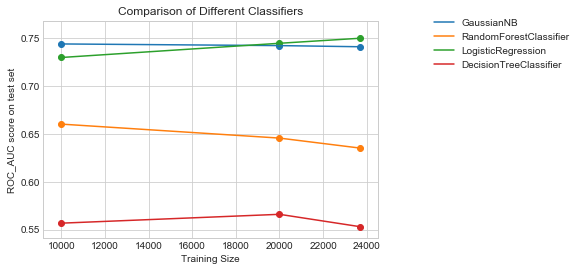

<Figure size 1008x576 with 0 Axes>

In [51]:
### Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, w2v_feature_array_test, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=(14,8))             
plt.show()

Logistic Regression has performed slightly better than GaussianNb classifier. So will go with LogisticRegressiona s our final mod and find the best parameters by using GridSearch and CrossValidation

### Grid Search & Cross-Validation

The grid search technique works by generating a grid of all possible provided parameter combinations. It then evaluates a model using a validation set based on every combination of parameters in the grid. It is used to find the optimum set of parameters for a learning algorithm given a data set.

The k-folds validation training technique creates multiple testing and training sets and trains a model on each, averaging the results. The splitting method is to divide the data into separate bins (for example k = 5), train on bins 1 to k-1 and test on bin k. The next fold trains on bins 2 to k and tests on bin 1 and so on, until all of the bins have acted as a test bin. This effectively trains and tests the models on all of the data without over-fitting to the data.

The benefits that this provides for grid search while optimizing the model is that there is less of a chance that the final model won't be optimized to data that could potentially have a bias. For example, if somehow, all of the training data didn't contain a unique data point (such as a high MEDV value for a low RM) the final model would be very biased not predict this scenario, and the optimization will make that worse. However, with k-folds validation, one of the trained models will see the unique data point and the result will be reflected in the final averaged model.

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
clf2 = LogisticRegression()
parameters = {'C' : [0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clf2, param_grid=parameters, cv=5, scoring='accuracy')
fitmodel.fit(w2v_feature_array_tr, y_train)
best_c = fitmodel.best_params_['C']

print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)
print('Best C :', best_c)

clf3 = LogisticRegression(C=best_c)
clf3.fit(w2v_feature_array_tr, y_train)
print(accuracy_score(clf3.predict(w2v_feature_array_test), y_test))

E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\An

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) {'C': 0.001} 0.9428112856901504
Best C : 0.001


E:\Anaconda_Files\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9391013007489161


ROC_AUC Score: 0.7092583835023034


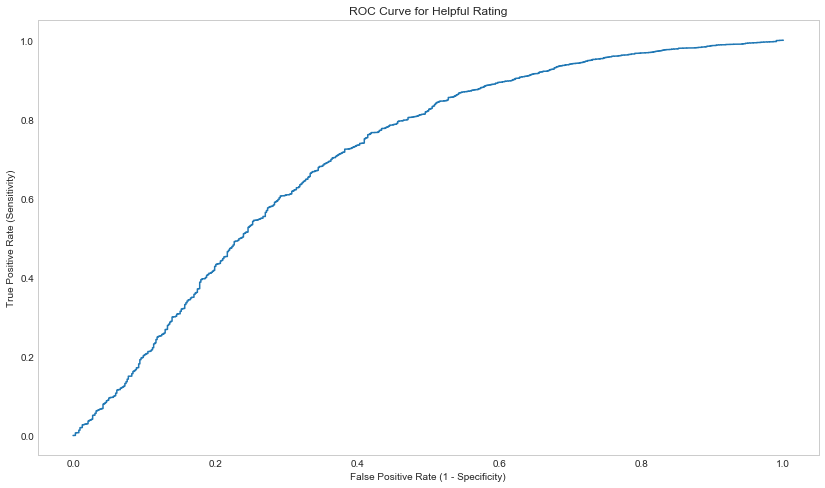

In [63]:

clf4 = fitmodel.best_estimator_
probas =clf4.predict_proba(w2v_feature_array_test)
plt.figure(figsize = (14,8))
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))